In [1]:
%reload_ext autoreload
#!pip install -r requirements.txt

In [2]:
%autoreload
from architectures.timegan_cnn_DG import *
from utils import *
from trainers import *
import numpy as np
np.random.seed(42)

trainset = DatasetSinus(num=600, seq_len=100, alpha=0.7, noise=0)
testset = DatasetSinus(num=300, seq_len=100, alpha=0.7, noise=0)
print(len(trainset))
print(trainset[0][0].size())


600
torch.Size([100, 3])


In [4]:
torch.tensor(trainset.T)

tensor([100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100,
        100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100,
        100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100,
        100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100,
        100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100,
        100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100,
        100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100,
        100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100,
        100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100,
        100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100,
        100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100,
        100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100,
        100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 1

In [9]:
%autoreload
import neptune.new as neptune
import torch

run = neptune.init_run(
    project="kohmann/timeGAN",
    name="timegan_cnn_DG",
    tags=["cnn","DG"],
    description="mac test",
    source_files=["timegan_cnn_DG.py"],
    capture_hardware_metrics=False,
    api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiI3YjFjNGY5MS1kOWU1LTRmZjgtOTNiYS0yOGI2NDdjZGYzNWUifQ==",
)

device = "cuda" if torch.cuda.is_available() else "cpu"

params = {
    "model_name": "model_cnn_dg_mac.pt",
    "n_epochs": 800,
    "l_rate": 0.001,
    "batch_size": 64,
    "num_layers": 2,
    "hidden_dim": 20,
    "Z_dim": 100,
    "dis_thresh": 0.15,
    "dataset": "sinus",
    "feature_dim": trainset[0][0].size(1),
    "max_seq_len": trainset[0][0].size(0),
    "trainset_size": len(trainset),
    "device": device,
    "optimizer": "Adam",
}
run["parameters"] = params

model = TimeGAN(params)
timegan_trainer(model, trainset, params, neptune_logger=run, continue_training=False)

# Generate random synthetic data
gen_z = timegan_generator(model, torch.tensor(testset.T), params["model_name"], torch.device(device), testset[0][0].size(0), 100)

log_visualizations(testset, gen_z, run) # logs pca, tsne, umap, mode_collapse
run["model_checkpoint"].upload(params["model_name"])

run.stop()

https://app.neptune.ai/kohmann/timeGAN/e/TIMEGAN-152
Remember to stop your run once you’ve finished logging your metadata (https://docs.neptune.ai/api/run#stop). It will be stopped automatically only when the notebook kernel/interactive console is terminated.

Start Embedding Network Training


Epoch: 1, Loss: nan:   0%|          | 2/800 [00:47<5:18:26, 23.94s/it]


KeyboardInterrupt: 

Shutting down background jobs, please wait a moment...
Done!
Waiting for the remaining 3 operations to synchronize with Neptune. Do not kill this process.
All 3 operations synced, thanks for waiting!
Explore the metadata in the Neptune app:
https://app.neptune.ai/kohmann/timeGAN/e/TIMEGAN-151


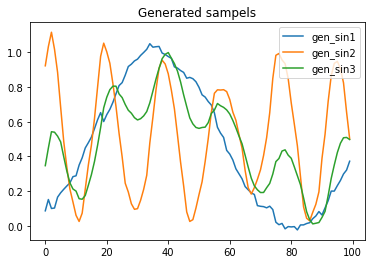

In [6]:
sample = 10
plt.plot(gen_z[sample][:, 0], label="gen_sin1")
plt.plot(gen_z[sample][:, 1], label="gen_sin2")
plt.plot(gen_z[sample][:, 2], label="gen_sin3")
plt.title("Generated sampels")
plt.legend()

In [6]:
def create_sin3(sin1, sin2, temporal=False):
    sin1, sin2 = np.array(sin1), np.array(sin2)
    e = 0.7  # temporal information weight
    seq_len = len(sin1)
    importance = np.array([e ** i for i in range(seq_len)])

    if temporal:
        sin3 = []
        for i in range(1, seq_len + 1):
            sin3.append(((importance[:i][::-1] * sin1[:i] + importance[:i][::-1] * sin2[:i]) / 2).sum())
        return sin3
    else:
        return [(s1 + s2) / 2 for s1, s2 in zip(sin1, sin2)]

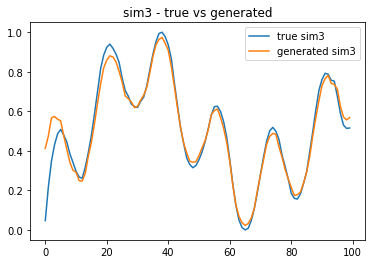

In [8]:
sample = 6
real_combo = create_sin3(gen_z[sample][:,0], gen_z[sample][:,1], temporal=True)
real_comb_scaled = minmaxscaler().fit_transform(torch.tensor([real_combo]))[0]
gen_combo = gen_z[sample][:,2]
plt.plot(real_comb_scaled, label="true sim3")
plt.plot(gen_combo, label="generated sim3")
plt.title("sim3 - true vs generated")
plt.legend()

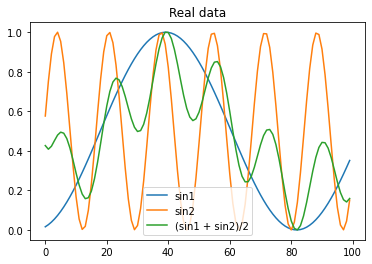

In [8]:
sample = trainset.__getitem__(9)
plt.plot(sample[0][:,0], label="sin1")
plt.plot(sample[0][:,1], label="sin2")
plt.plot(sample[0][:,2], label="(sin1 + sin2)/2")
plt.title("Real data")
plt.legend()

In [ ]:
real_comb = create_sin3(gen_z[sample][:,0], gen_z[sample][:,0], temporal=True)
real_comb_scaled = minmaxscaler().fit_transform(torch.tensor([real_combo]))
plt.plot(real_comb_scaled[0])

### CNN layer testing

In [1]:
def printLayerShapes(layers, input):
    for layer in layers:
        output = layer(input)

        print(f"{type(layer).__name__:13}: {list(input.size())} --> {list(output.size())}")
        input = output

In [2]:
import torch
import torch.nn as nn
hidden_dim = 20
max_seq_len = 100
input = torch.randn(2, max_seq_len, hidden_dim)


## Discriminator
layers = nn.Sequential(
            nn.Conv1d(in_channels=100, out_channels=20, kernel_size=(5), stride=2, bias=False)
            , nn.BatchNorm1d(20)
            , nn.LeakyReLU()
            , nn.Conv1d(in_channels=20, out_channels=40, kernel_size=(7), stride=2, bias=False)
            , nn.BatchNorm1d(40)
            , nn.LeakyReLU()
            , nn.Flatten(start_dim=1)
            , nn.Linear(40, 1)
        )
print(f"Discriminator architecture\nInput: {input.size()}\n")
printLayerShapes(layers, input)

Discriminator architecture
Input: torch.Size([2, 100, 20])

Conv1d       : [2, 100, 20] --> [2, 20, 8]
BatchNorm1d  : [2, 20, 8] --> [2, 20, 8]
LeakyReLU    : [2, 20, 8] --> [2, 20, 8]
Conv1d       : [2, 20, 8] --> [2, 40, 1]
BatchNorm1d  : [2, 40, 1] --> [2, 40, 1]
LeakyReLU    : [2, 40, 1] --> [2, 40, 1]
Flatten      : [2, 40, 1] --> [2, 40]
Linear       : [2, 40] --> [2, 1]


In [15]:
## Generator architecture
Z_dim = 100
hidden_dim = 20
max_seq_len = 100
input = torch.randn(2, max_seq_len, Z_dim)


layers = nn.Sequential(
            nn.Conv1d(in_channels=100, out_channels=100, kernel_size=(6), stride=2, bias=False)
            , nn.BatchNorm1d(100)
            , nn.LeakyReLU()
            , nn.Conv1d(in_channels=100, out_channels=100, kernel_size=(9), stride=2, bias=True)
            , nn.Sigmoid()
        )

print(f"Generator architecture\nInput: {input.size()}\n")
printLayerShapes(layers, input)

Generator architecture
Input: torch.Size([2, 100, 100])

Conv1d       : [2, 100, 100] --> [2, 100, 48]
BatchNorm1d  : [2, 100, 48] --> [2, 100, 48]
LeakyReLU    : [2, 100, 48] --> [2, 100, 48]
Conv1d       : [2, 100, 48] --> [2, 100, 20]
Sigmoid      : [2, 100, 20] --> [2, 100, 20]


In [ ]:
## Generator architecture LINEAR
Z_dim = 1
hidden_dim = 20
max_seq_len = 100
input = torch.randn(16, max_seq_len, Z_dim)
input = input.squeeze(dim=2)


layers = nn.Sequential(
            nn.Linear(in_features=100, out_features=200, bias=True)
            ,nn.LayerNorm(200)
            ,nn.LeakyReLU()
            ,nn.Linear(in_features=200, out_features=400, bias=True)
            ,nn.LayerNorm(400)
            ,nn.LeakyReLU()
            ,nn.Linear(in_features=200, out_features=1000, bias=True)
            ,nn.LayerNorm(400)
            ,nn.LeakyReLU()
        )


print(f"Generator architecture\nInput: {input.size()}\n")
printLayerShapes(layers, input)

In [ ]:
torch.randn(16,300).view(-1,100,3).size()